# Graph Neural Network - Spatial Domain

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from gnn_models import SimpleGNNFilter, VanillaGNNFilter, GeneralGNNFilter, GINFilter
from graph_utils import from_image_to_graph

### Message Passing

- Consider a Node
- *Aggregate* its direct neighbors
- *Update* the state of the Node with a new embedding
- Perform this on all the Nodes in order to have a new embedding for each
- This is a *message passing step*
- The size of the node embedding is a hyper-parameter

### Load images to graph and preprocess them

#### Input image

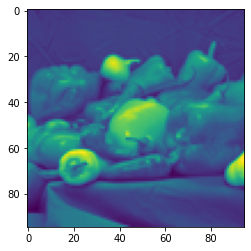

In [2]:
# load the input image and get its adjacency matrix and nodes
XA, XH = from_image_to_graph('images/input.png')

# the input image is (95,95)
# we will train a batch of 1 image
XA = XA[np.newaxis, :] # [1, 9025, 9025]
XH = XH[np.newaxis, :] # [1, 9025, 1]

plt.imshow(XH.reshape((95,95)))
plt.show()

#### Target images

Similarly, let's load the target images

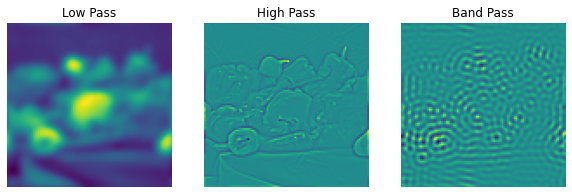

In [3]:
# low pass output
YA_low, YH_low = from_image_to_graph('Images/low_pass.png')
YA_low = YA_low[np.newaxis, :]
YH_low = YH_low[np.newaxis, :]

# high pass output
YA_high, YH_high = from_image_to_graph('Images/high_pass.png')
YA_high = YA_high[np.newaxis, :]
YH_high = YH_high[np.newaxis, :]

# band pass output
YA_band, YH_band = from_image_to_graph('Images/band_pass.png')
YA_band = YA_band[np.newaxis, :]
YH_band = YH_band[np.newaxis, :]

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.axis('off')
plt.imshow(YH_low.reshape((95,95)))
plt.title('Low Pass')

plt.subplot(132)
plt.axis('off')
plt.imshow(YH_high.reshape((95,95)))
plt.title('High Pass')

plt.subplot(133)
plt.axis('off')
plt.imshow(YH_band.reshape((95,95)))
plt.title('Band Pass')
plt.show()

## Training

The goal is to evaluate the ability of several GNN models to perform filtering. Indeed, by seeing if these architectures can learn how to perform low-pass, high-pass and band-pass filtering, we will have a better sense of their expressive power.

In [4]:
def plot_predictions(target, pred):
    plt.figure(figsize=(9,9))
    plt.subplot(121)
    plt.imshow(target.reshape((95,95)))
    plt.title('Target')
    plt.subplot(122)
    plt.imshow(pred.numpy().reshape((95,95))) # prediction of the trained model
    plt.title('Prediction')
    plt.show()

### Simple GNN

$H^{l+1} = \sigma(A H^l W^l)$

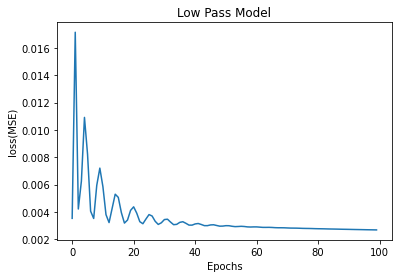

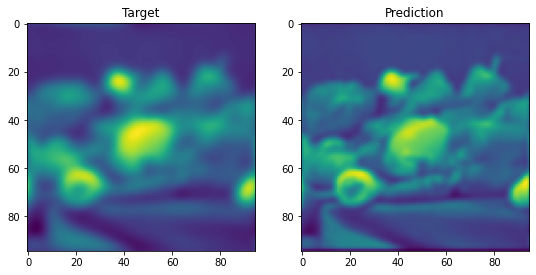

In [5]:
# low pass model
model_low = SimpleGNNFilter()
model_low.compile(optimizer='Adam', loss='mse') # MSE will minimize the difference between
                                                # the node embeddings of the input image
                                                # and the ones of the target image (result of filtering)
        
history_low = model_low.fit([XA, XH], YH_low, epochs = 100, verbose=False, batch_size = 1)
pred = model_low([XA, XH])

plt.plot(history_low.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss(MSE)')
plt.title('Low Pass Model')
plot_predictions(YH_low, pred)

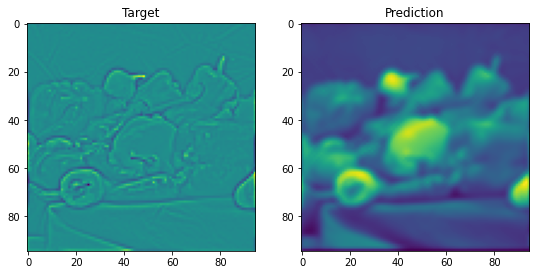

In [6]:
# high pass model
model_high = SimpleGNNFilter()
model_high.compile(optimizer='Adam', loss='mse') 
                                                
history_high = model_high.fit([XA, XH], YH_high, epochs = 100, verbose=False, batch_size = 1)
pred = model_high([XA, XH])

plot_predictions(YH_high, pred)

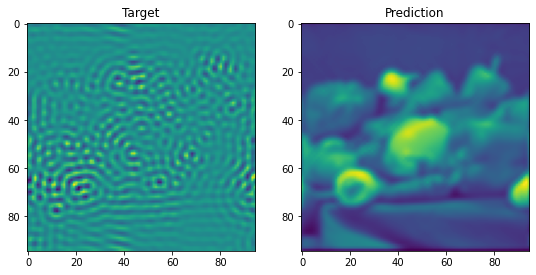

In [7]:
# band pass model
model_band = SimpleGNNFilter()
model_band.compile(optimizer='Adam', loss='mse') 
                                                
history_band = model_band.fit([XA, XH], YH_band, epochs = 200, verbose=False, batch_size = 1)
pred = model_band([XA, XH])

plot_predictions(YH_band, pred)

**The simple GNN seems to be restricted to low-pass filtering.**

**Notes**

Applying these experiments to the Vanilla GNN Filter will lead to similar results. It is indeed limited to low-pass filtering too.

### General GNN

$H^{l+1} = \sigma(\sum_{k}C_k H^l W_k^l)$ with $C_1 = I$ and $C_2 = A$

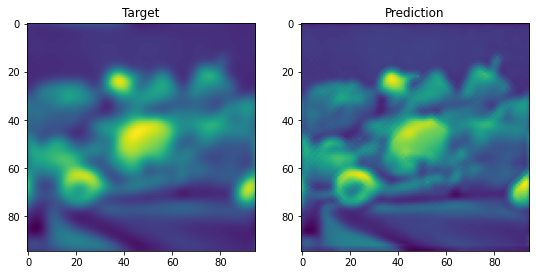

In [8]:
# low pass
model_low = GeneralGNNFilter()
model_low.compile(optimizer='Adam', loss='mse') 
        
history_low = model_low.fit([XA, XH], YH_low, epochs = 500, verbose=False, batch_size = 1)
pred = model_low([XA, XH])

plot_predictions(YH_low, pred)

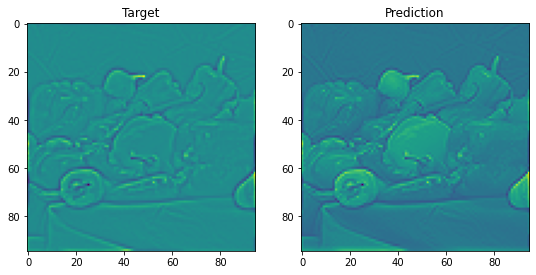

In [9]:
# high pass model
model_high = GeneralGNNFilter()
model_high.compile(optimizer='Adam', loss='mse') 
                                                
history_high = model_high.fit([XA, XH], YH_high, epochs = 1000, verbose=False, batch_size = 1)
pred = model_high([XA, XH])

plot_predictions(YH_high, pred)

**The General GNN can learn how to perform high-pass filtering.**

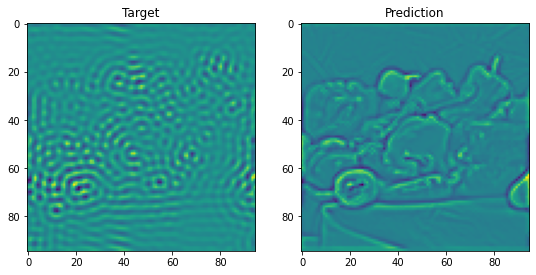

In [10]:
# band pass model
model_band = GeneralGNNFilter()
model_band.compile(optimizer='Adam', loss='mse') 
                                                
history_band = model_band.fit([XA, XH], YH_band, epochs = 1000, verbose=False, batch_size = 1)
pred = model_band([XA, XH])

plot_predictions(YH_band, pred)

## GIN

We fixed the epsilon parameters with negative values.

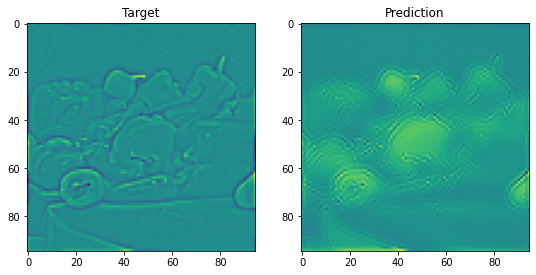

In [9]:
# high pass model
model_high = GINFilter()
model_high.compile(optimizer='Adam', loss='mse') 
                                                
history_high = model_high.fit([XA, XH], YH_high, epochs = 1000, verbose=False, batch_size = 1)
pred = model_high([XA, XH])

plot_predictions(YH_high, pred)

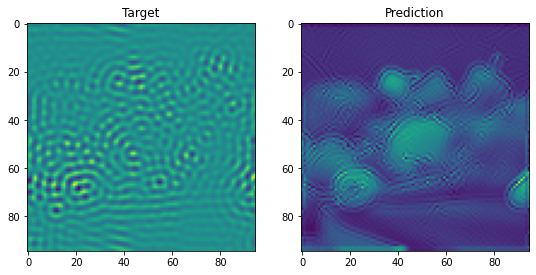

In [8]:
# band pass model
model_band = GINFilter()
model_band.compile(optimizer='Adam', loss='mse') 
                                                
history_band = model_band.fit([XA, XH], YH_band, epochs = 300, verbose=False, batch_size = 1)
pred = model_band([XA, XH])

plot_predictions(YH_band, pred)

## ChebNet

In [ ]:
import time
# band pass model
model_band = ChebFilter()
model_band.compile(optimizer='Adam', loss='mse') 

# lambda_max
t0 = time.time()
X_lambda_max = get_lambda_max(XA)
print('Eigen decomposition took : ', time.time() - t0)

In [ ]:
history_band = model_band.fit([XA, XH, X_lambda_max], YH_band, epochs = 5, verbose=True, batch_size = 1)
pred = model_band([XA, XH, X_lambda_max])

plot_predictions(YH_band, pred)